In [85]:
import numpy as np 
import pandas as pd 
from river.datasets import synth
from river.datasets import AirlinePassengers, Elec2
import river.preprocessing as rpreprocessing
import river.linear_model as rlinear_model
import river.optim as roptim
from river import metrics
from river import evaluate
from river import metrics
import river.compose as rcompose
from river import multiclass
import matplotlib.pyplot as plt 
from river import tree

# Task 1 - Hyper-parameter tuning 

In [213]:
datastream1 = synth.RandomRBFDrift(seed_model=42, seed_sample=42, n_classes=2, n_features=10, n_centroids=20, n_drift_centroids=10, change_speed=0.1)
datastream2 = synth.LEDDrift(seed=42, noise_percentage=0.2, n_drift_features=2)
datastream3 = AirlinePassengers() # Only 144 items 
datastream4 = Elec2()

In [214]:
# Create and store the datastreams 

data1 = datastream1.take(5000)
df1 = pd.DataFrame([{**x, "class": y} for x, y in data1])

data2 = datastream2.take(5000)
df2 = pd.DataFrame([{**x, "class": y} for x, y in data2])

data3 = datastream3.take(k=144)
df3 = pd.DataFrame([{**x, "class": y} for x, y in data3])

data4 = datastream4.take(5000)
if datastream4.is_downloaded: # Check if the csv with the datastream is downloaded 
    df4 = pd.read_csv(datastream4.path) # Load the csv file into a dataframe 
else:
    df4 = pd.DataFrame([{**x, "class": y} for x, y in data4])


df3["month"] = pd.to_datetime(df3["month"])
df3["year"] = df3["month"].dt.year
df3["day"] = df3["month"].dt.day
df3["month"] = df3["month"].dt.month

df4.loc[df4["class"] == "UP", "class"] = 1
df4.loc[df4["class"] == "DOWN", "class"] = 0

df1.to_csv("./Datastreams/datastream1.csv")
df2.to_csv("./Datastreams/datastream2.csv")
df3.to_csv("./Datastreams/datastream3.csv")
df4.to_csv("./Datastreams/datastream4.csv")

In [2]:
# Load datastreams 

df1 = pd.read_csv("./Datastreams/datastream1.csv").drop('Unnamed: 0',axis=1)
df2 = pd.read_csv("./Datastreams/datastream2.csv").drop('Unnamed: 0',axis=1)
df3 = pd.read_csv("./Datastreams/datastream3.csv").drop('Unnamed: 0',axis=1)
df4 = pd.read_csv("./Datastreams/datastream4.csv").drop('Unnamed: 0',axis=1)

In [3]:
def df_to_dataset(df):
    """ Takes as an input a pandas dataframe and returns a dataset in the form of
    progressive_val_score input"""

    columns = [col for col in df.columns if col != "class"]
    dataset = []
    
    for _, row in df.iterrows():
        data =  ({col: row[col] for col in columns}, row["class"])
        dataset.append(data)
    
    return dataset

In [49]:
datasets = [df_to_dataset(df1), df_to_dataset(df2), df_to_dataset(df3), df_to_dataset(df4)]

### Linear Models

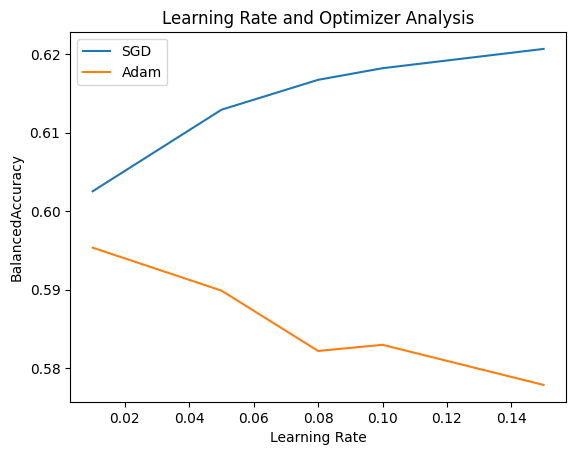

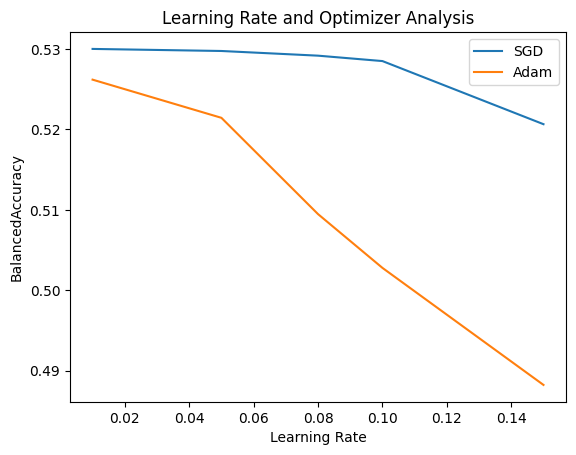

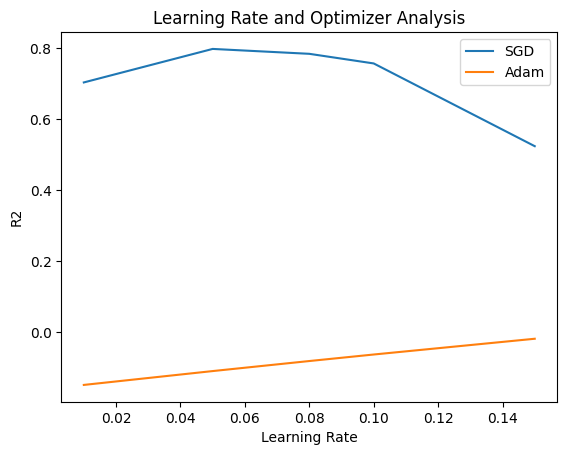

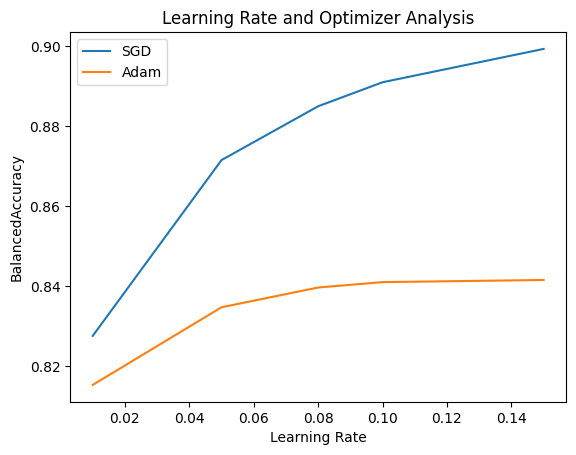

In [56]:
LEARNING_RATES = [0.01, 0.05, 0.08, 0.1, 0.15]
OPTIMIZERS = [roptim.SGD, roptim.Adam]

# Metric for classification tasks 
# Balanced accuracy : better than simply accuracy, can handle imbalanced datastreams
classification_metric = metrics.BalancedAccuracy()

# Metric for regression tasks
# Because R^2 is bounded easirerto used it for comparissons
regression_metric = metrics.R2()


for dataset in datasets:

    results = []
        
    for opt in OPTIMIZERS:
        row = []
        for lr in LEARNING_RATES:
            # For binary classification tasks (datastream 1 and datasteam 4)
            model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=opt(lr=lr))))
            
            # For regression tasks (datasteram 3)
            model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('lin_reg', rlinear_model.LinearRegression(optimizer=opt(lr=lr))))
            
            # For multiclass classification using OneVSOne approach (datastream 2)
            model3 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', multiclass.OneVsOneClassifier(rlinear_model.LogisticRegression(optimizer=opt(lr=lr)))))
            
            if dataset == datasets[0] or dataset == datasets[3]:
                model = model1
                metric =  metrics.BalancedAccuracy()
            elif dataset == datasets[2]:
                model = model2
                metric = metrics.R2()
            else:
                model = model3
                metric =  metrics.BalancedAccuracy()

            row.append(evaluate.progressive_val_score(dataset, model, metric).get())

        results.append(row)

    fig, ax = plt.subplots()
    for i in range(len(results)):
        ax.plot(LEARNING_RATES, results[i], label=OPTIMIZERS[i].__name__)

    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(type(metric).__name__)
    ax.set_title("Learning Rate and Optimizer Analysis")
    ax.legend()

    plt.show()


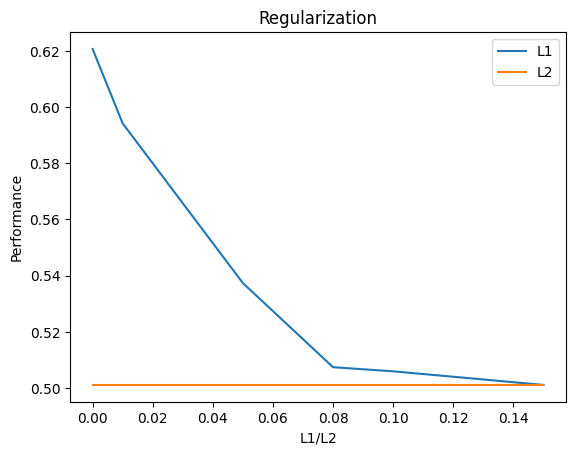

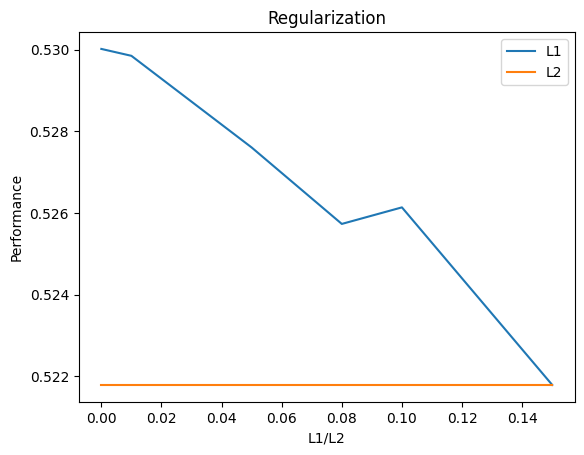

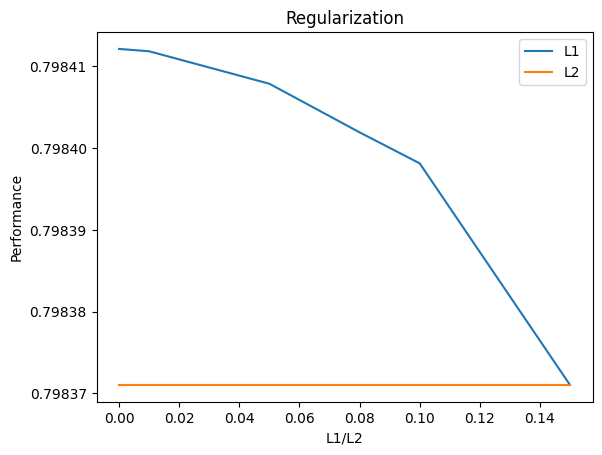

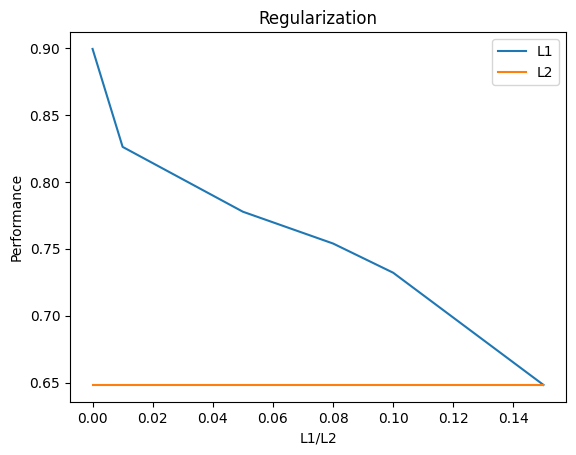

In [84]:
L1 = [0, 0.01, 0.05, 0.08, 0.1, 0.15]
L2 = [0, 0.01, 0.05, 0.08, 0.1, 0.15]

l1_results = []
l2_results = []

for l1 in L1: 
    model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l1=l1)))
    
    model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('log_reg', multiclass.OneVsOneClassifier(rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.01), l1=l1))))
    
    model3 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('lin_reg', rlinear_model.LinearRegression(optimizer=roptim.SGD(lr=0.05), l1=l1)))

    model4 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l1=l1)))
    
    l1_row = []
    
    l1_row.append(evaluate.progressive_val_score(datasets[0], model1, metrics.BalancedAccuracy()).get())
    l1_row.append(evaluate.progressive_val_score(datasets[1], model2, metrics.BalancedAccuracy()).get()) 
    l1_row.append(evaluate.progressive_val_score(datasets[2], model3, metrics.R2()).get()) 
    l1_row.append(evaluate.progressive_val_score(datasets[3], model4, metrics.BalancedAccuracy()).get())  

    l1_results.append(l1_row)

for l2 in L2: 
    model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l2=l2)))
    
    model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('log_reg', multiclass.OneVsOneClassifier(rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.01), l2=l2))))
    
    model3 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('lin_reg', rlinear_model.LinearRegression(optimizer=roptim.SGD(lr=0.05), l2=l2)))

    model4 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('log_reg', rlinear_model.LogisticRegression(optimizer=roptim.SGD(lr=0.15), l2=l2)))
    
    l2_row = []
    
    l2_row.append(evaluate.progressive_val_score(datasets[0], model1, metrics.BalancedAccuracy()).get())
    l2_row.append(evaluate.progressive_val_score(datasets[1], model2, metrics.BalancedAccuracy()).get()) 
    l2_row.append(evaluate.progressive_val_score(datasets[2], model3, metrics.R2()).get()) 
    l2_row.append(evaluate.progressive_val_score(datasets[3], model4, metrics.BalancedAccuracy()).get())  

    l2_results.append(l1_row)

l1_results = np.array(l1_results)
l2_results = np.array(l2_results)

for i in range(len(datasets)):
    fig, ax = plt.subplots()
    ax.plot(L1,l1_results[:,i], label="L1")
    ax.plot(L2,l2_results[:,i], label="L2")
    ax.set_xlabel("L1/L2")
    ax.set_ylabel("Performance")
    ax.set_title("Regularization")
    ax.legend()

### Hoeffding Tree

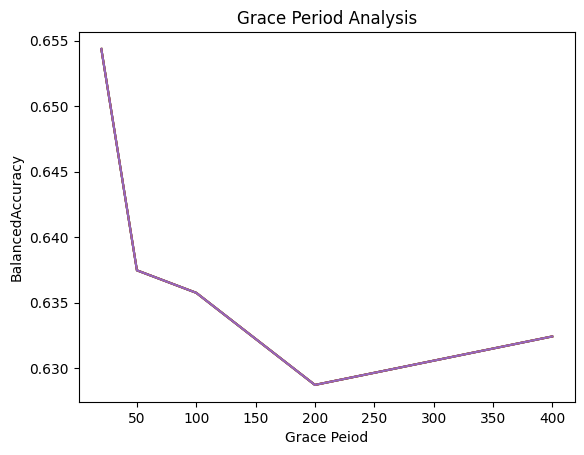

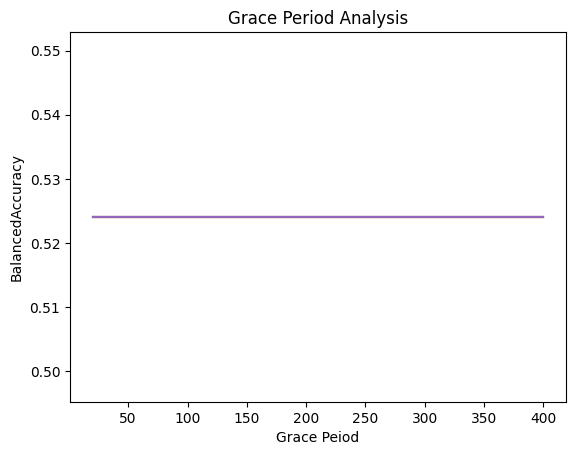

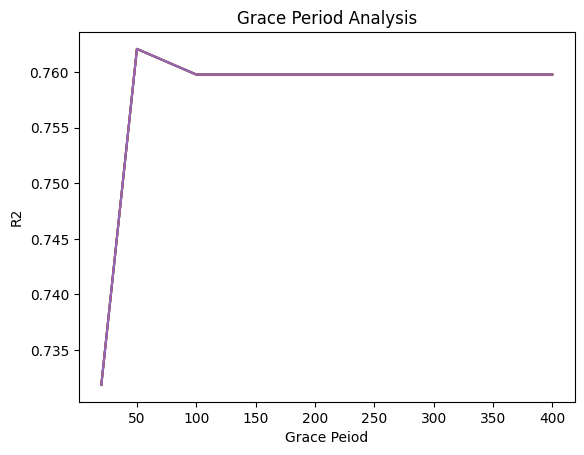

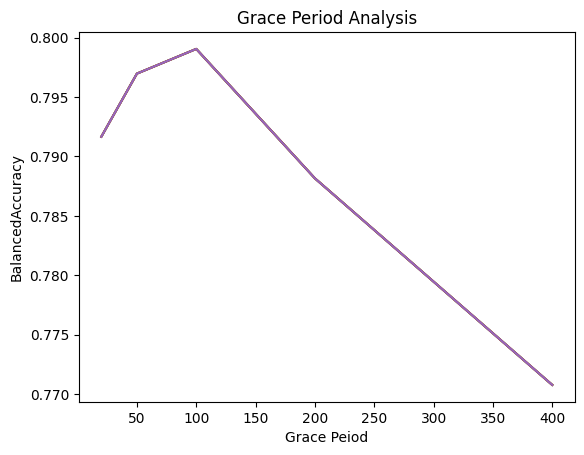

In [100]:
GRACE_PERIOD = [20, 50, 100, 200, 400]


for dataset in datasets:
    results = []
    for grace in GRACE_PERIOD:

        model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('HTree', tree.HoeffdingTreeClassifier(grace_period=grace)))
        model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('HTree', tree.HoeffdingTreeRegressor(grace_period=grace)))
        
        if dataset == datasets[2]:
            model = model2
            metric = metrics.R2()
        else:
            model = model1 
            metric = metrics.BalancedAccuracy()

        results.append(evaluate.progressive_val_score(dataset, model, metric).get())

    fig, ax = plt.subplots()
    for i in range(len(results)):
        ax.plot(GRACE_PERIOD, results)

    ax.set_xlabel("Grace Peiod")
    ax.set_ylabel(type(metric).__name__)
    ax.set_title("Grace Period Analysis")

    plt.show()

/var/folders/xw/ft78v7xn3sj2f6gvm1d1wxq40000gn/T/ipykernel_94942/1479941567.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


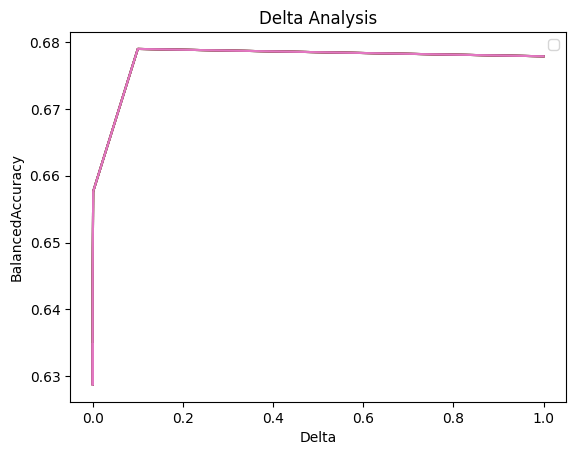

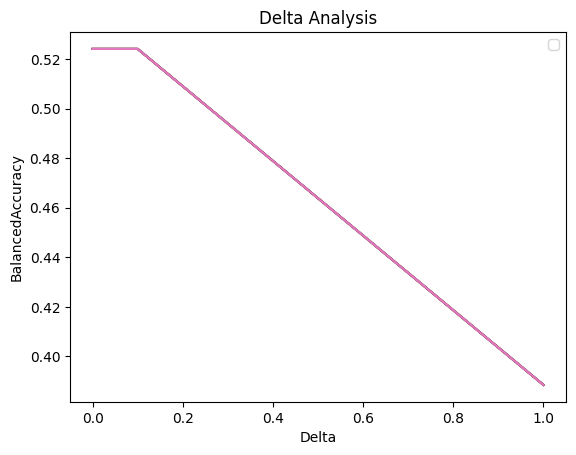

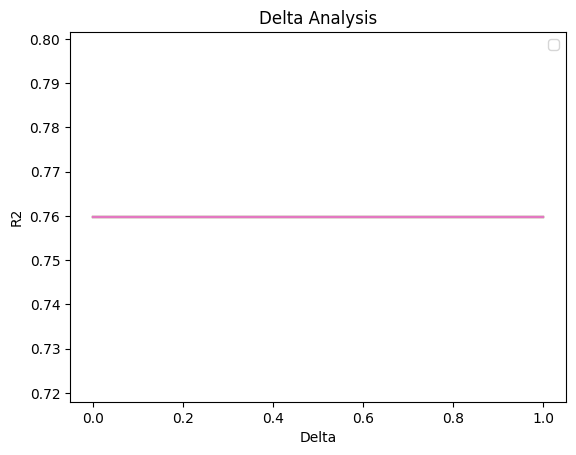

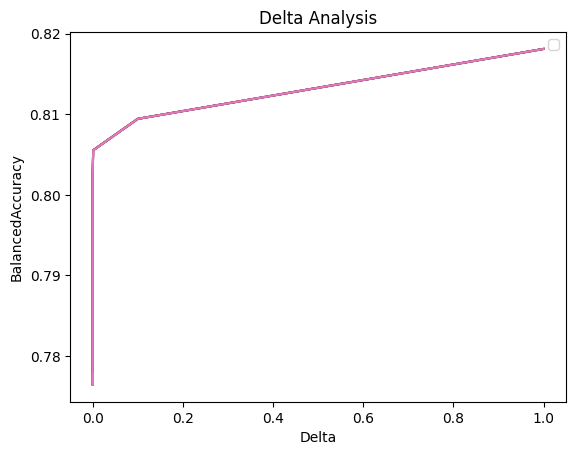

In [ ]:
DELTAS = [1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1]


for dataset in datasets:
    results = []
    for delta in DELTAS:

        model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('HTree', tree.HoeffdingTreeClassifier(delta=delta)))
        model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('HTree', tree.HoeffdingTreeRegressor(delta=delta)))
        
        if dataset == datasets[2]:
            model = model2
            metric = metrics.R2()
        else:
            model = model1 
            metric = metrics.BalancedAccuracy()

        results.append(evaluate.progressive_val_score(dataset, model, metric).get())

    fig, ax = plt.subplots()
    for i in range(len(results)):
        ax.plot(DELTAS, results)

    ax.set_xlabel("Delta")
    ax.set_ylabel(type(metric).__name__)
    ax.set_title("Delta Analysis")

    plt.show()

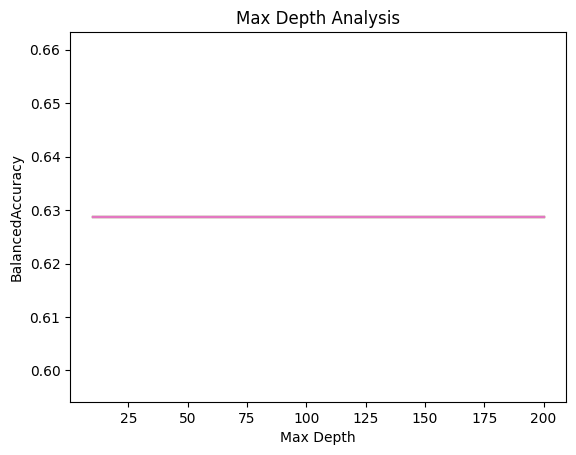

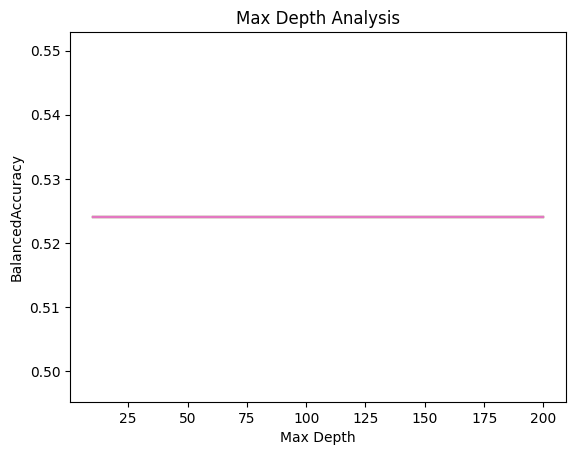

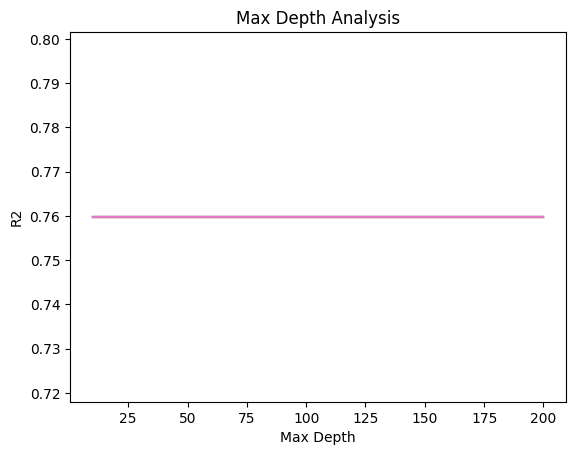

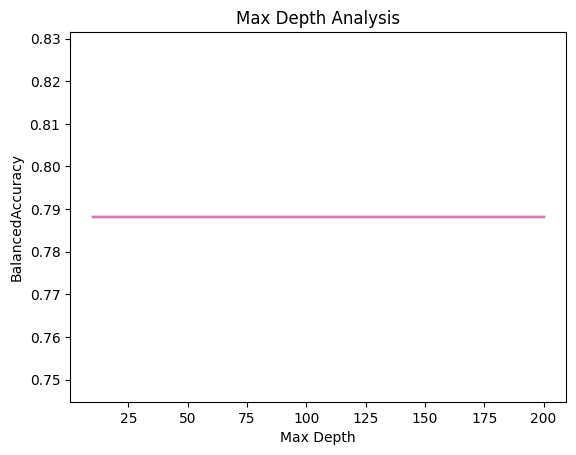

In [103]:
MAX_DEPTH = [10, 20, 50, 80, 100, 150, 200]


for dataset in datasets:
    results = []
    for depth in MAX_DEPTH:

        model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('HTree', tree.HoeffdingTreeClassifier(max_depth=depth)))
        model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('HTree', tree.HoeffdingTreeRegressor(max_depth=depth)))
        
        if dataset == datasets[2]:
            model = model2
            metric = metrics.R2()
        else:
            model = model1 
            metric = metrics.BalancedAccuracy()

        results.append(evaluate.progressive_val_score(dataset, model, metric).get())

    fig, ax = plt.subplots()
    for i in range(len(results)):
        ax.plot(MAX_DEPTH, results)

    ax.set_xlabel("Max Depth")
    ax.set_ylabel(type(metric).__name__)
    ax.set_title("Max Depth Analysis")

    plt.show()

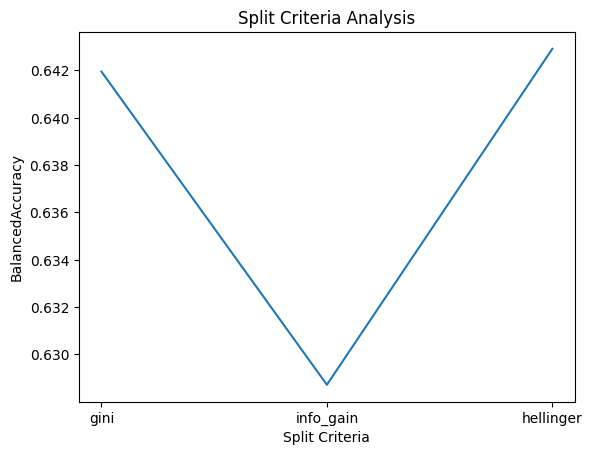

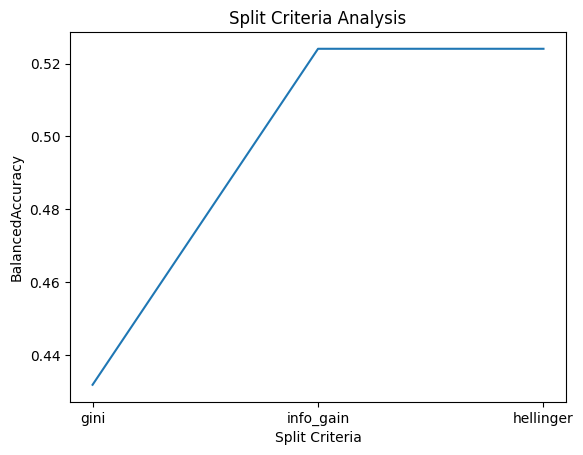

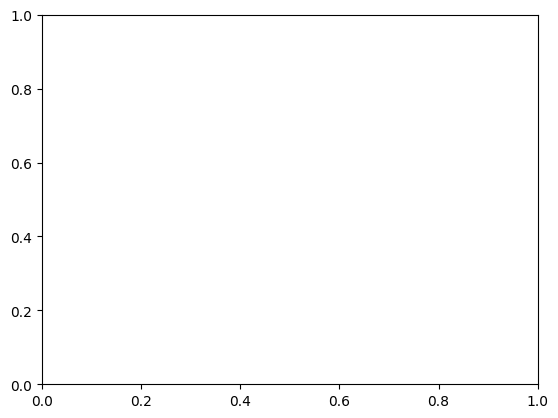

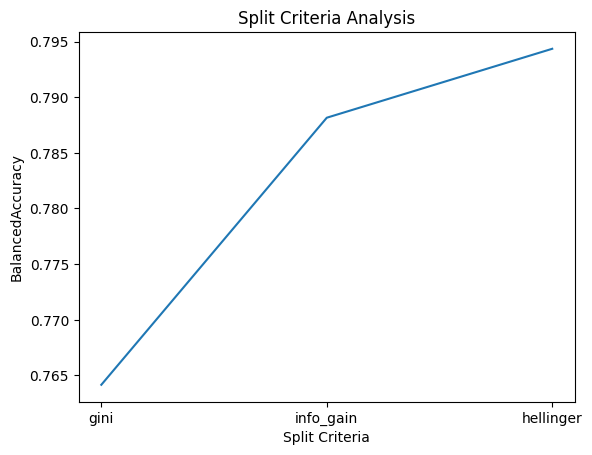

In [ ]:
SPLIT_CRITERIA =["gini", "info_gain", "hellinger"]


for dataset in datasets:
    results = []
    for split in SPLIT_CRITERIA:

        model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                    ('HTree', tree.HoeffdingTreeClassifier(split_criterion=split)))
        # model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
        #                     ('HTree', tree.HoeffdingTreeRegressor(s=depth)))
        
        if dataset == datasets[2]:
            # model = model2
            # metric = metrics.R2()
            break
        else:
            model = model1 
            metric = metrics.BalancedAccuracy()

        results.append(evaluate.progressive_val_score(dataset, model, metric).get())

    fig, ax = plt.subplots()
    
    if len(results) > 0:
        ax.plot(SPLIT_CRITERIA, results)

        ax.set_xlabel("Split Criteria")
        ax.set_ylabel(type(metric).__name__)
        ax.set_title("Split Criteria Analysis")

        plt.show()

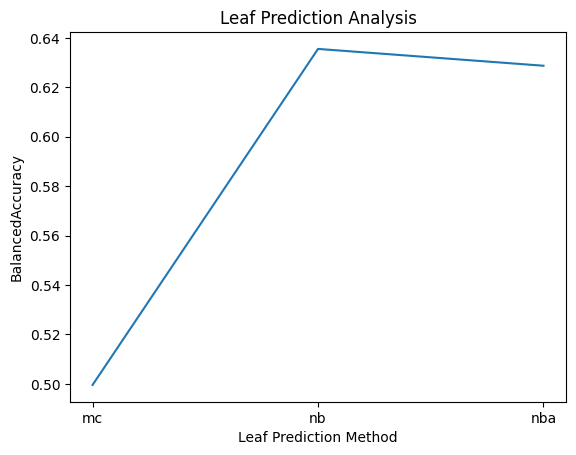

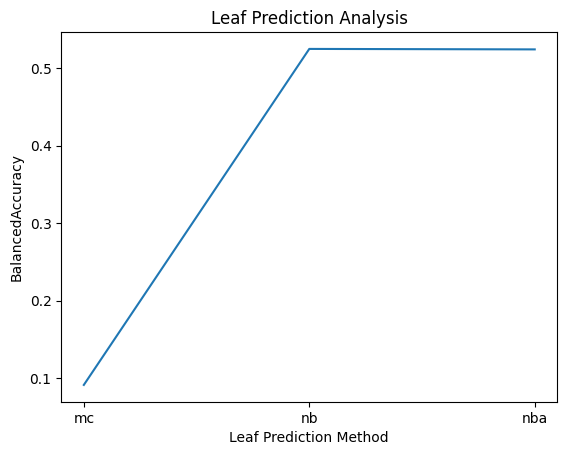

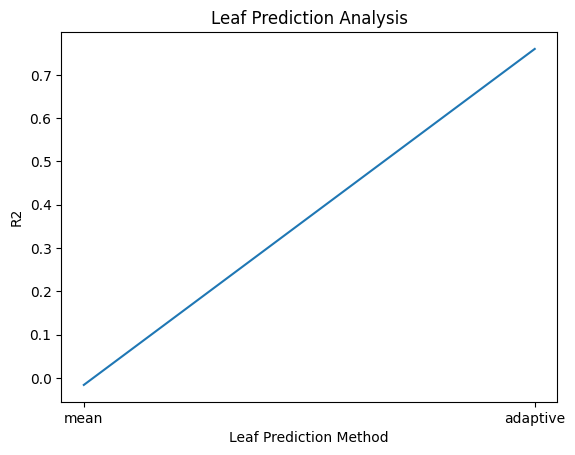

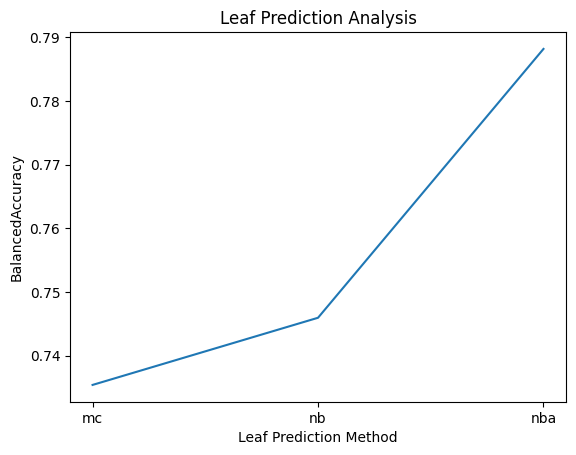

In [109]:
LEAF_PREDICTION_CLASS = ['mc', 'nb', 'nba']
LEAF_PREDICTION_REG = ['mean', 'adaptive']

for dataset in datasets:
    results = []
    if dataset != datasets[2]:
        for pred in LEAF_PREDICTION_CLASS:

            model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                        ('HTree', tree.HoeffdingTreeClassifier(leaf_prediction=pred)))
            
            model = model1 
            metric = metrics.BalancedAccuracy()

            results.append(evaluate.progressive_val_score(dataset, model, metric).get())

        fig, ax = plt.subplots()

        ax.plot(LEAF_PREDICTION_CLASS, results)

        ax.set_xlabel("Leaf Prediction Method")
        ax.set_ylabel(type(metric).__name__)
        ax.set_title("Leaf Prediction Analysis")

        plt.show()
        
    else:
        for pred in LEAF_PREDICTION_REG:

            model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                ('HTree', tree.HoeffdingTreeRegressor(leaf_prediction=pred)))
            model = model2
            metric = metrics.R2()

            results.append(evaluate.progressive_val_score(dataset, model, metric).get())

        fig, ax = plt.subplots()

        ax.plot(LEAF_PREDICTION_REG, results)

        ax.set_xlabel("Leaf Prediction Method")
        ax.set_ylabel(type(metric).__name__)
        ax.set_title("Leaf Prediction Analysis")

        plt.show()

In [ ]:
model_class = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                                ('HTree', tree.HoeffdingTreeClassifier()))

model_reg = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                              ('HTree', tree.HoeffdingTreeRegressor()))


model1 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                           ('HTree', tree.HoeffdingTreeClassifier(grace_period=20,
                                                                    delta=0.1,
                                                                    split_criterion='hellinger',
                                                                    leaf_prediction='nb')))

model2 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                           ('HTree', tree.HoeffdingTreeClassifier(grace_period=50,
                                                                    delta=0.1,
                                                                    split_criterion='hellinger',
                                                                    leaf_prediction='nb')))

model3 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                            ('HTree', tree.HoeffdingTreeRegressor(grace_period=50,
                                                                  delta=0.1,
                                                                  leaf_prediction='adaptive')))

model4 = rcompose.Pipeline(('scale', rpreprocessing.StandardScaler()),
                           ('HTree', tree.HoeffdingTreeClassifier(grace_period=100,
                                                                    delta=1,
                                                                    split_criterion='hellinger',
                                                                    leaf_prediction='nba')))


print("Datastream 1 Accuracy without tuning: ", evaluate.progressive_val_score(datasets[0], model_class, metrics.Accuracy()).get()) 
print("Datastream 1 Accuracy with tuning: ", evaluate.progressive_val_score(datasets[0], model1, metrics.Accuracy()).get()) 

print("Datastream 2 Accuracy without tuning: ", evaluate.progressive_val_score(datasets[1], model_class, metrics.Accuracy()).get()) 
print("Datastream 2 Accuracy with tuning: ", evaluate.progressive_val_score(datasets[1], model2, metrics.Accuracy()).get()) 

print("Datastream 3 Accuracy without tuning: ", evaluate.progressive_val_score(datasets[2], model_reg, metrics.R2()).get()) 
print("Datastream 3 Accuracy with tuning: ", evaluate.progressive_val_score(datasets[2], model3, metrics.R2()).get()) 

print("Datastream 4 Accuracy without tuning: ", evaluate.progressive_val_score(datasets[3], model_class, metrics.Accuracy()).get()) 
print("Datastream 4 Accuracy with tuning: ", evaluate.progressive_val_score(datasets[3], model4, metrics.Accuracy()).get()) 

Datastream 1 Accuracy without tuning:  0.6863372674534907
Datastream 1 Accuracy with tuning:  0.6873374674934987
Datastream 2 Accuracy without tuning:  0.4404
Datastream 2 Accuracy with tuning:  0.5253050610122024
Datastream 3 Accuracy without tuning:  0.7597761027766107
Datastream 3 Accuracy with tuning:  0.7620806921760266
Datastream 4 Accuracy without tuning:  0.5379590395480226
Datastream 4 Accuracy with tuning:  0.8186312374478604
